## 1. Environmental Setup

In [2]:
# =============================================================================
# 1. Load Libraries
# =============================================================================
import os
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow

from pyproj import Transformer
from rasterio.enums import Resampling

In [3]:
# =============================================================================
# 2. Set the parameters
# =============================================================================

# Input raster maps:
# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\pixel2"
# path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\object2"
# time_points = [2010, 2012, 2014, 2016, 2018, 2021]
# class_name = "PIE"
# is_binary_data = True # Set to True for 0/1 data

path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\collection6"
path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\collection8"
time_points = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
class_name = "savanna"
is_binary_data = True # Set to True for 0/1 data

# path_series_x = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\x"
# path_series_y = r"C:\Users\AntFonseca\github\compare-time-series\input\toydata\y"
# time_points = [0, 1, 2]
# class_name = "toydata"
# is_binary_data = True # Set to True for 0/1 data

# Output folder
output_path = r"C:\Users\AntFonseca\github\compare-time-series\output4"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# NoData values
nodata_value = 255

print("✅ Parameters successfully defined.")

✅ Parameters successfully defined.


## 2. Definition of Caculation Functions

In [4]:
# =============================================================================
# 2. definition of all calculation functions
# =============================================================================

# 2.1 helper function for data reading
# =====================================
raster_arrays = {}

def get_raster_array(year):
    """
    Reads a pair of raster files (x and y) for a given year or returns it from the
    cache if it has already been read previously in this cell.
    """
    if year in raster_arrays:
        return raster_arrays[year]
    
    file_name = f"{class_name}{year}.tif"
    path_x = os.path.join(
        path_series_x,
        file_name
    )
    path_y = os.path.join(
        path_series_y,
        file_name
    )

    if not os.path.exists(path_x) or not os.path.exists(path_y):
        print(f"Warning: File '{file_name}' not found for year {year}.")
        return None, None

    with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        raster_arrays[year] = (array_x, array_y)
        return array_x, array_y

# 2.2 metrics calculation functions
# ===================================
def calculate_presence_metrics(file_x, file_y):
    """
    Calculates presence agreement metrics for a single time point.
    """
    with rasterio.open(file_x) as src_x, rasterio.open(file_y) as src_y:
        array_x = src_x.read(1)
        array_y = src_y.read(1)
        
        valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
        
        presence_x = array_x[valid_mask]
        presence_y = array_y[valid_mask]
        
        hits = np.sum(np.minimum(presence_x, presence_y))
        total_x = np.sum(presence_x)
        total_y = np.sum(presence_y)
        
        hits = hits.astype(np.int64)
        total_x = total_x.astype(np.int64)
        total_y = total_y.astype(np.int64)
        
        space_difference = np.minimum(total_x, total_y) - hits
        misses = np.maximum(0, total_x - total_y)
        false_alarms = np.maximum(0, total_y - total_x)
        
        return {
            "Hit": hits,
            "Miss": misses,
            "False Alarm": false_alarms,
            "Space Difference": space_difference,
            "Total X": total_x,
            "Total Y": total_y
        }

def calculate_change_metrics(year_t, year_t_minus_1):
    """
    Calculates all gross change metrics (gains and losses) for a single time interval.
    """
    array_x_t, array_y_t = get_raster_array(year_t)
    array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)

    if array_x_t is None or array_x_t_minus_1 is None:
        return None

    valid_mask = (
        (array_x_t != nodata_value) &
        (array_y_t != nodata_value) &
        (array_x_t_minus_1 != nodata_value) &
        (array_y_t_minus_1 != nodata_value)
    )

    change_x = np.subtract(array_x_t, array_x_t_minus_1, dtype=np.int16)
    change_y = np.subtract(array_y_t, array_y_t_minus_1, dtype=np.int16)

    gain_x = np.maximum(0, change_x)
    gain_y = np.maximum(0, change_y)
    loss_x = np.minimum(0, change_x)
    loss_y = np.minimum(0, change_y)
    
    gain_total_x = np.sum(gain_x)
    gain_total_y = np.sum(gain_y)
    loss_total_x = np.sum(loss_x)
    loss_total_y = np.sum(loss_y)
    
    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)

    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    
    return {
        "Gain Hit": gain_hit,
        "Gain Miss": gain_miss,
        "Gain False Alarm": gain_false_alarm,
        "Gain Space Difference": gain_space_diff,
        "Loss Hit": loss_hit,
        "Loss Miss": loss_miss,
        "Loss False Alarm": loss_false_alarm,
        "Loss Space Difference": loss_space_diff,
        "Gain Total X": gain_total_x,
        "Gain Total Y": gain_total_y,
        "Loss Total X": loss_total_x,
        "Loss Total Y": loss_total_y
    }

def calculate_extent_metrics(time_points_list):
    """
    Calculates gross change metrics for the entire temporal extent.
    """
    start_year, end_year = time_points_list[0], time_points_list[-1]
    
    array_x_start, array_y_start = get_raster_array(start_year)
    array_x_end, array_y_end = get_raster_array(end_year)

    if array_x_start is None or array_x_end is None:
        return None

    valid_mask = (
        (array_x_start != nodata_value) &
        (array_y_start != nodata_value) &
        (array_x_end != nodata_value) &
        (array_y_end != nodata_value)
    )

    change_x = np.subtract(array_x_end, array_x_start, dtype=np.int16)
    change_y = np.subtract(array_y_end, array_y_start, dtype=np.int16)

    gain_x = np.maximum(0, change_x)
    gain_y = np.maximum(0, change_y)
    loss_x = np.minimum(0, change_x)
    loss_y = np.minimum(0, change_y)
    
    gain_total_x = np.sum(gain_x)
    gain_total_y = np.sum(gain_y)
    loss_total_x = np.sum(loss_x)
    loss_total_y = np.sum(loss_y)

    gain_hit = np.sum(np.minimum(gain_x, gain_y))
    gain_space_diff = np.minimum(gain_total_x, gain_total_y) - gain_hit
    gain_miss = np.maximum(0, gain_total_x - gain_total_y)
    gain_false_alarm = np.maximum(0, gain_total_y - gain_total_x)

    loss_hit = np.sum(np.maximum(loss_x, loss_y))
    loss_space_diff = np.maximum(loss_total_x, loss_total_y) - loss_hit
    loss_miss = np.minimum(0, loss_total_x - loss_total_y)
    loss_false_alarm = np.minimum(0, loss_total_y - loss_total_x)
    
    return {
        "Gain Hit": gain_hit,
        "Gain Miss": gain_miss,
        "Gain False Alarm": gain_false_alarm,
        "Gain Space Difference": gain_space_diff,
        "Loss Hit": loss_hit,
        "Loss Miss": loss_miss,
        "Loss False Alarm": loss_false_alarm,
        "Loss Space Difference": loss_space_diff
    }

def calculate_net_change_components(gross_results):
    """
    Calculates the Net Change components from a set of Gross Change results.
    """
    if not gross_results:
        return None
        
    Ght = gross_results.get("Gain Hit", 0)
    Gut = gross_results.get("Gain Space Difference", 0)
    Gmt = gross_results.get("Gain Miss", 0)
    Gft = gross_results.get("Gain False Alarm", 0)
    Lht = gross_results.get("Loss Hit", 0)
    Lut = gross_results.get("Loss Space Difference", 0)
    Lmt = gross_results.get("Loss Miss", 0)
    Lft = gross_results.get("Loss False Alarm", 0)

    QGxt = np.maximum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QGyt = np.maximum(0, Ght + Gut + Gft + Lht + Lut + Lft)
    QLxt = np.minimum(0, Ght + Gut + Gmt + Lht + Lut + Lmt)
    QLyt = np.minimum(0, Ght + Gut + Gft + Lht + Lut + Lft)

    net_gain_hit = np.minimum(QGxt, QGyt)
    net_gain_miss = np.maximum(0, QGxt - QGyt)
    net_gain_false_alarm = np.maximum(0, QGyt - QGxt)
    
    net_loss_hit = np.maximum(QLxt, QLyt)
    net_loss_miss = np.minimum(0, QLxt - QLyt)
    net_loss_false_alarm = np.minimum(0, QLyt - QLxt)
    
    return {
        "Gain Hit": net_gain_hit,
        "Gain Miss": net_gain_miss,
        "Gain False Alarm": net_gain_false_alarm,
        "Loss Hit": net_loss_hit,
        "Loss Miss": net_loss_miss,
        "Loss False Alarm": net_loss_false_alarm,
        "QG_Total_X": QGxt,
        "QG_Total_Y": QGyt,
        "QL_Total_X": QLxt,
        "QL_Total_Y": QLyt
    }

print("✅ All calculation functions are defined.")

✅ All calculation functions are defined.


## 3. Execute the functions

In [5]:
# =============================================================================
# 3. central execution of all calculations
# =============================================================================
print("Starting all data processing and calculations...")

# --- 3.1 Presence Agreement Calculations ---
print("\nCalculating Presence Agreement metrics...")
results_by_time = {}
for year in time_points:
    file_name = f"{class_name}{year}.tif"
    file_x = os.path.join(
        path_series_x,
        file_name
    )
    file_y = os.path.join(
        path_series_y,
        file_name
    )
    if os.path.exists(file_x) and os.path.exists(file_y):
        results_by_time[year] = calculate_presence_metrics(file_x, file_y)

sum_results = {
    "Hit": 0,
    "Space Difference": 0,
    "Total X": 0,
    "Total Y": 0
}
for year in results_by_time:
    sum_results["Hit"] += results_by_time[year]["Hit"]
    sum_results["Space Difference"] += results_by_time[year]["Space Difference"]
    sum_results["Total X"] += results_by_time[year]["Total X"]
    sum_results["Total Y"] += results_by_time[year]["Total Y"]

sum_results["Time Difference"] = (
    np.minimum(sum_results["Total X"], sum_results["Total Y"])
    - sum_results["Hit"]
    - sum_results["Space Difference"]
)
sum_results["Miss"] = np.maximum(
    0, sum_results["Total X"] - sum_results["Total Y"]
)
sum_results["False Alarm"] = np.maximum(
    0, sum_results["Total Y"] - sum_results["Total X"]
)
print("Presence Agreement calculations complete.")

# --- 3.2 Gross Change Calculations ---
print("\nCalculating Gross Change metrics...")
change_results_by_interval = {}
time_intervals = []
for i in range(1, len(time_points)):
    year_t = time_points[i]
    year_t_minus_1 = time_points[i-1]
    interval_label = f"{year_t_minus_1}-{year_t}"
    time_intervals.append(interval_label)
    change_results_by_interval[interval_label] = calculate_change_metrics(
        year_t,
        year_t_minus_1
    )

extent_results = calculate_extent_metrics(time_points)
sum_change_results = {
    "Gain Hit": 0, "Gain Space Difference": 0, "Gain Total X": 0,
    "Gain Total Y": 0, "Gain Time Difference": 0, "Loss Hit": 0,
    "Loss Space Difference": 0, "Loss Total X": 0, "Loss Total Y": 0,
    "Loss Time Difference": 0,
}
for interval in time_intervals:
    results = change_results_by_interval.get(interval)
    if results:
        for key in [
            "Gain Hit", "Gain Space Difference", "Gain Total X", "Gain Total Y",
            "Loss Hit", "Loss Space Difference", "Loss Total X", "Loss Total Y"
        ]:
            sum_change_results[key] += results[key]

sum_change_results["Gain Time Difference"] = (
    np.minimum(sum_change_results["Gain Total X"], sum_change_results["Gain Total Y"])
    - sum_change_results["Gain Hit"]
    - sum_change_results["Gain Space Difference"]
)
sum_change_results["Gain Miss"] = np.maximum(
    0, sum_change_results["Gain Total X"] - sum_change_results["Gain Total Y"]
)
sum_change_results["Gain False Alarm"] = np.maximum(
    0, sum_change_results["Gain Total Y"] - sum_change_results["Gain Total X"]
)
sum_change_results["Loss Time Difference"] = (
    np.maximum(sum_change_results["Loss Total X"], sum_change_results["Loss Total Y"])
    - sum_change_results["Loss Hit"]
    - sum_change_results["Loss Space Difference"]
)
sum_change_results["Loss Miss"] = np.minimum(
    0, sum_change_results["Loss Total X"] - sum_change_results["Loss Total Y"]
)
sum_change_results["Loss False Alarm"] = np.minimum(
    0, sum_change_results["Loss Total Y"] - sum_change_results["Loss Total X"]
)
print("Gross Change calculations complete.")

# --- 3.3 Net Change Calculations ---
print("\nCalculating Net Change metrics...")
net_change_by_interval = {}
for interval_label, gross_results in change_results_by_interval.items():
    net_change_by_interval[interval_label] = calculate_net_change_components(
        gross_results
    )
net_extent_results = calculate_net_change_components(extent_results)

sum_net_results = {
    "QG_Total_X": 0, "QG_Total_Y": 0, "QL_Total_X": 0,
    "QL_Total_Y": 0, "Gain Hit": 0, "Loss Hit": 0
}
for interval, results in net_change_by_interval.items():
    if results:
        sum_net_results["QG_Total_X"] += results["QG_Total_X"]
        sum_net_results["QG_Total_Y"] += results["QG_Total_Y"]
        sum_net_results["QL_Total_X"] += results["QL_Total_X"]
        sum_net_results["QL_Total_Y"] += results["QL_Total_Y"]
        sum_net_results["Gain Hit"] += results["Gain Hit"]
        sum_net_results["Loss Hit"] += results["Loss Hit"]

sum_net_results["Gain Miss"] = np.maximum(
    0, sum_net_results["QG_Total_X"] - sum_net_results["QG_Total_Y"]
)
sum_net_results["Gain False Alarm"] = np.maximum(
    0, sum_net_results["QG_Total_Y"] - sum_net_results["QG_Total_X"]
)
sum_net_results["Loss Miss"] = np.minimum(
    0, sum_net_results["QL_Total_X"] - sum_net_results["QL_Total_Y"]
)
sum_net_results["Loss False Alarm"] = np.minimum(
    0, sum_net_results["QL_Total_Y"] - sum_net_results["QL_Total_X"]
)
sum_net_results["Gain Time Difference"] = (
    np.minimum(sum_net_results["QG_Total_X"], sum_net_results["QG_Total_Y"])
    - sum_net_results["Gain Hit"]
)
sum_net_results["Loss Time Difference"] = (
    np.maximum(sum_net_results["QL_Total_X"], sum_net_results["QL_Total_Y"])
    - sum_net_results["Loss Hit"]
)
print("Net Change calculations complete.")

print("\n✅ All calculations are complete and results are stored in memory.")

Starting all data processing and calculations...

Calculating Presence Agreement metrics...
Presence Agreement calculations complete.

Calculating Gross Change metrics...
Gross Change calculations complete.

Calculating Net Change metrics...
Net Change calculations complete.

✅ All calculations are complete and results are stored in memory.


## 4. Plot the graphics

#### 4.1 Presence

In [ ]:
# =============================================================================
# 2. Making the graphic
# =============================================================================
print("\nMaking the graphic...")

mpl.rcParams['font.family'] = 'serif'

labels = [str(tp) for tp in time_points] + ["Sum"]
hits = [results_by_time.get(tp, {}).get("Hit", 0) for tp in time_points] + [sum_results["Hit"]]
space_diff = [results_by_time.get(tp, {}).get("Space Difference", 0) for tp in time_points] + [sum_results["Space Difference"]]
time_diff = [0] * len(time_points) + [sum_results["Time Difference"]]
misses = [results_by_time.get(tp, {}).get("Miss", 0) for tp in time_points] + [sum_results["Miss"]]
false_alarms = [results_by_time.get(tp, {}).get("False Alarm", 0) for tp in time_points] + [sum_results["False Alarm"]]
# reference_line = [results_by_time.get(tp, {}).get("Total X", 0) for tp in time_points]
# comparison_line = [results_by_time.get(tp, {}).get("Total Y", 0) for tp in time_points]

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(labels))

ax.axhline(
    0,
    color='black',
    linewidth=0.8
)
ax.bar(labels,
       hits,
       label='Agreement',
       color='black',
       bottom=bottom);bottom += np.array(hits)
ax.bar(labels,
       space_diff,
       label='Space Difference',
       color='grey',
       bottom=bottom); bottom += np.array(space_diff)
ax.bar(labels,
       time_diff,
       label='Time Difference',
       color='lightgray',
       bottom=bottom); bottom += np.array(time_diff)
ax.bar(labels,
       misses,
       label='y<x',
       color='white',
       edgecolor='black',
       hatch='\\\\\\',
       bottom=bottom);bottom += np.array(misses)
ax.bar(labels,
       false_alarms,
       label='x>y',
       color='white',
       edgecolor='black',
       hatch='///',
       bottom=bottom)
# ax.plot(labels[:-1],
#         reference_line,
#         's-g',
#         label='Collection 6',
#         linewidth=2,
#         markersize=8)
# ax.plot(labels[:-1],
#         comparison_line,
#         'd--y',
#         label='Collection 8',
#         linewidth=2,
#         markersize=8)

handles, labels_list = ax.get_legend_handles_labels()
order = [
#     "Collection 6",
#     "Collection 8",
    "y<x",
    "x>y",
    "Time Difference",
    "Space Difference",
    "Agreement"]

legend_dict = dict(zip(labels_list, handles))
ordered_handles = [legend_dict[label] for label in order]
ordered_labels = order
ax.legend(ordered_handles,
          ordered_labels,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          frameon=False)

ax.set_title('Time Points and Sum',
             fontsize=14)
ax.set_xlabel('Time Point',
              fontsize=12)

# =============================================================================
# --- y-axis scale settings (choose one option) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel(
#     'Presence',
#     fontsize=12
# )

# # # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    """Formats the y-axis tick by dividing by 1 million."""
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
# ax.set_ylim(0, 450_000_000) # Optional: uncomment to set manual limits
ax.set_ylabel(
    'Presence (Million pixels)',
    fontsize=12
)

# =============================================================================

plt.tight_layout(rect=[0, 0, 0.85, 1])

output_filename = f'presence_agreement_{class_name}.png'
final_chart_path = os.path.join(output_path,
                                 output_filename)

plt.savefig(final_chart_path,
            dpi=300)

plt.show()

print(f"\n✅Processing complete. Graphic saved as: {final_chart_path}")

#### 4.2 Gross Change

In [ ]:
# =============================================================================
# 5. making the graphic
# =============================================================================
print("\nGenerating the Gains and Losses graphic...")

# --- prepare data for plotting ---
plot_data_list = []
for interval in time_intervals:
    row_data = change_results_by_interval.get(interval, {})
    row_data['Interval'] = interval
    plot_data_list.append(row_data)

sum_row_gross = sum_change_results.copy()
sum_row_gross['Interval'] = 'Sum'
plot_data_list.append(sum_row_gross)

extent_row_gross = extent_results.copy()
extent_row_gross['Interval'] = 'Extent'
plot_data_list.append(extent_row_gross)

df_plot = pd.DataFrame(plot_data_list).set_index('Interval')
df_plot = df_plot.fillna(0)

# --- ensure renamed columns exist if upstream still used "Hit" ---
df_plot = df_plot.rename(
    columns={
        'Gain Hit': 'Gain Agreement',
        'Loss Hit': 'Loss Agreement'
    }
)

# --- setup for the plot ---
labels = df_plot.index.tolist()

gain_colors = {
    'Agreement': '#0070C0',
    'Space Difference': '#00B0F0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Agreement': '#C00000',
    'Space Difference': '#FF0000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}
gain_hatch_color = '#0070C0'
loss_hatch_color = '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- plotting gains ---
bottom_gain = np.zeros(len(labels))
for comp in ["Agreement", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    # choose display label for legend
    if comp == "Miss":
        disp = "y<x"  # presence/gain condition
    elif comp == "False Alarm":
        disp = "x>y"  # presence/gain condition
    else:
        disp = comp

    # column key (note: Miss/False Alarm remain in data column names)
    col = f"Gain {comp}" if comp in ["Agreement", "Space Difference", "Time Difference"] else f"Gain {comp}"
    data = df_plot[col].values

    if comp in ["Miss", "False Alarm"]:
        plot_data = data.copy().astype(float)
        plot_data[plot_data == 0] = np.nan
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Gain {disp}',
            color='white',
            bottom=bottom_gain,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_gain,
            edgecolor=gain_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Gain {disp}',
            color=gain_colors[comp],
            bottom=bottom_gain,
            edgecolor='none'
        )
    bottom_gain += data

# --- plotting losses ---
bottom_loss = np.zeros(len(labels))
for comp in ["Agreement", "Space Difference", "Time Difference", "Miss", "False Alarm"]:
    # choose display label for legend
    if comp == "Miss":
        disp = "|y|<|x|"  # loss condition
    elif comp == "False Alarm":
        disp = "|x|>|y|"  # loss condition
    else:
        disp = comp

    col = f"Loss {comp}" if comp in ["Agreement", "Space Difference", "Time Difference"] else f"Loss {comp}"
    data = df_plot[col].values

    if comp in ["Miss", "False Alarm"]:
        plot_data = data.copy().astype(float)
        plot_data[plot_data == 0] = np.nan
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Loss {disp}',
            color='white',
            bottom=bottom_loss,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_loss,
            edgecolor=loss_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Loss {disp}',
            color=loss_colors[comp],
            bottom=bottom_loss,
            edgecolor='none'
        )
    bottom_loss += data

# --- final graphic settings ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Gross Loss and Gain During Time Intervals', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)

# =============================================================================
# --- y-axis scale settings (choose one option) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel('Gross Loss and Gross Gain', fontsize=12)

# # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_ylim(-25_000_000, 10_000_000)
ax.set_ylabel('Gross Loss and Gross Gain (Million pixels)', fontsize=12)

# =============================================================================

# --- logic to order the legend ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

# custom patches for hatched entries with new math labels already used above
legend_dict['Gain y<x'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain x>y'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss |y|<|x|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss |x|>|y|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain y<x', 'Gain x>y', 'Gain Time Difference',
    'Gain Space Difference', 'Gain Agreement',
    'Loss |y|<|x|', 'Loss |x|>|y|', 'Loss Time Difference',
    'Loss Space Difference', 'Loss Agreement'
]

ordered_handles = [legend_dict.get(label) for label in order if label in legend_dict]
ordered_labels = [label for label in order if label in legend_dict]

legend = ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    alignment='left'
)
legend.get_title().set_ha('left')
for text in legend.get_texts():
    text.set_ha('left')

# --- save the graphic ---
output_filename = f'gross_change_{class_name}.png'
final_path = os.path.join(output_path, output_filename)

plt.savefig(final_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Processing complete. Graphic saved as: {final_path}")


#### 4.3 Net Change

In [ ]:
# =============================================================================
# 5. making the net change graphic
# =============================================================================
print("\nGenerating the Net Change graphic...")

# --- prepare data for plotting ---
net_plot_data_list = []
for interval in time_intervals:
    row_data = net_change_by_interval.get(interval, {})
    row_data['Interval'] = interval
    net_plot_data_list.append(row_data)

sum_row_net = sum_net_results.copy()
sum_row_net['Interval'] = 'Sum'
net_plot_data_list.append(sum_row_net)

extent_row_net = net_extent_results.copy()
extent_row_net['Interval'] = 'Extent'
net_plot_data_list.append(extent_row_net)

df_plot_net = pd.DataFrame(net_plot_data_list).set_index('Interval')
df_plot_net = df_plot_net.fillna(0)


# --- setup for the plot ---
labels = df_plot_net.index.tolist()
gain_colors = {
    'Hit': '#0070C0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Hit': '#C00000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}
gain_hatch_color, loss_hatch_color = '#0070C0', '#FF0000'

fig, ax = plt.subplots(
    figsize=(14, 8)
)
mpl.rcParams['font.family'] = 'serif'

# --- plotting net gains ---
bottom_gain = np.zeros(len(labels))
for comp in [
    "Hit",
    "Time Difference",
    "Miss",
    "False Alarm"
]:
    # Get the original data with zeros for stacking calculations
    data = df_plot_net[f"Gain {comp}"].values
    
    # Create a copy for plotting, replacing 0 with NaN
    plot_data = data.copy().astype(float)
    plot_data[plot_data == 0] = np.nan
    
    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data, # Use data with NaNs for plotting
            label=f'Gain {comp}',
            color='white',
            bottom=bottom_gain,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data, # Use data with NaNs for plotting
            color='none',
            bottom=bottom_gain,
            edgecolor=gain_hatch_color,
            hatch=hatch
        )
    else:
        # Use original data for solid bars as they have no problematic edge
        ax.bar(
            labels,
            data,
            label=f'Gain {comp}',
            color=gain_colors[comp],
            bottom=bottom_gain,
            edgecolor='none'
        )
    # Always update the bottom with the original data (containing zeros)
    bottom_gain += data

# --- plotting net losses ---
bottom_loss = np.zeros(len(labels))
for comp in [
    "Hit",
    "Time Difference",
    "Miss",
    "False Alarm"
]:
    # Get the original data with zeros for stacking calculations
    data = df_plot_net[f"Loss {comp}"].values

    # Create a copy for plotting, replacing 0 with NaN
    plot_data = data.copy().astype(float)
    plot_data[plot_data == 0] = np.nan
        
    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data, # Use data with NaNs for plotting
            label=f'Loss {comp}',
            color='white',
            bottom=bottom_loss,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data, # Use data with NaNs for plotting
            color='none',
            bottom=bottom_loss,
            edgecolor=loss_hatch_color,
            hatch=hatch
        )
    else:
        # Use original data for solid bars
        ax.bar(
            labels,
            data,
            label=f'Loss {comp}',
            color=loss_colors[comp],
            bottom=bottom_loss,
            edgecolor='none'
        )
    # Always update the bottom with the original data (containing zeros)
    bottom_loss += data

# --- final graphic settings ---
ax.axhline(
    0,
    color='black',
    linewidth=0.8
)
ax.set_title(
    'Net Loss and Gain During Time Intervals',
    fontsize=14
)
ax.set_xlabel(
    'Time Interval',
    fontsize=12
)

# =============================================================================
# --- Y-AXIS SCALE SETTINGS (CHOOSE ONE OPTION) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel(
#     'Net Loss and Net Gain',
#     fontsize=12
# )

# # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    """Formats the y-axis tick by dividing by 1 million."""
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_ylim(-25_000_000, 10_000_000) # Optional: uncomment to set manual limits
ax.set_ylabel(
    'Net Loss and Net Gain (Million pixels)',
    fontsize=12
)

# =============================================================================

# --- logic to order the legend ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

legend_dict['Gain Miss'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain False Alarm'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss Miss'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss False Alarm'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain Miss', 'Gain False Alarm', 'Gain Time Difference', 'Gain Hit',
    'Loss Miss', 'Loss False Alarm', 'Loss Time Difference', 'Loss Hit'
]

ordered_handles = [legend_dict.get(label) for label in order if label in legend_dict]
ordered_labels = [label for label in order if label in legend_dict]

legend = ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    alignment='left'
)
legend.get_title().set_ha('left')
for text in legend.get_texts():
    text.set_ha('left')

# --- save the graphic ---
output_filename = f'net_change_{class_name}_col6_8_graphic.png'
final_path = os.path.join(
    output_path,
    output_filename
)

plt.savefig(
    final_path,
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print(f"\n✅ Processing complete. Graphic saved as: {final_path}")

In [ ]:
# =============================================================================
# 5. making the net change graphic
# =============================================================================
print("\nGenerating the Net Change graphic...")

# --- prepare data for plotting ---
net_plot_data_list = []
for interval in time_intervals:
    row_data = net_change_by_interval.get(interval, {})
    row_data['Interval'] = interval
    net_plot_data_list.append(row_data)

sum_row_net = sum_net_results.copy()
sum_row_net['Interval'] = 'Sum'
net_plot_data_list.append(sum_row_net)

extent_row_net = net_extent_results.copy()
extent_row_net['Interval'] = 'Extent'
net_plot_data_list.append(extent_row_net)

df_plot_net = pd.DataFrame(net_plot_data_list).set_index('Interval')
df_plot_net = df_plot_net.fillna(0)

# --- ensure renamed columns if upstream still uses "Hit" ---
df_plot_net = df_plot_net.rename(
    columns={
        'Gain Hit': 'Gain Agreement',
        'Loss Hit': 'Loss Agreement'
    }
)

# --- setup for the plot ---
labels = df_plot_net.index.tolist()
gain_colors = {
    'Agreement': '#0070C0',
    'Time Difference': '#BDD7EE',
    'Miss': 'white',
    'False Alarm': 'white'
}
loss_colors = {
    'Agreement': '#C00000',
    'Time Difference': '#FF9696',
    'Miss': 'white',
    'False Alarm': 'white'
}
gain_hatch_color, loss_hatch_color = '#0070C0', '#FF0000'

fig, ax = plt.subplots(figsize=(14, 8))
mpl.rcParams['font.family'] = 'serif'

# --- plotting net gains ---
bottom_gain = np.zeros(len(labels))
for comp in ["Agreement", "Time Difference", "Miss", "False Alarm"]:
    # display label mapping
    if comp == "Miss":
        disp = "y<x"
    elif comp == "False Alarm":
        disp = "x>y"
    else:
        disp = comp

    data = df_plot_net[f"Gain {comp}"].values
    plot_data = data.copy().astype(float)
    plot_data[plot_data == 0] = np.nan

    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Gain {disp}',
            color='white',
            bottom=bottom_gain,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_gain,
            edgecolor=gain_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Gain {disp}',
            color=gain_colors[comp],
            bottom=bottom_gain,
            edgecolor='none'
        )
    bottom_gain += data

# --- plotting net losses ---
bottom_loss = np.zeros(len(labels))
for comp in ["Agreement", "Time Difference", "Miss", "False Alarm"]:
    # display label mapping
    if comp == "Miss":
        disp = "|y|<|x|"
    elif comp == "False Alarm":
        disp = "|x|>|y|"
    else:
        disp = comp

    data = df_plot_net[f"Loss {comp}"].values
    plot_data = data.copy().astype(float)
    plot_data[plot_data == 0] = np.nan

    if comp in ["Miss", "False Alarm"]:
        hatch = '///' if comp == 'False Alarm' else '\\\\\\'
        ax.bar(
            labels,
            plot_data,
            label=f'Loss {disp}',
            color='white',
            bottom=bottom_loss,
            edgecolor='black'
        )
        ax.bar(
            labels,
            plot_data,
            color='none',
            bottom=bottom_loss,
            edgecolor=loss_hatch_color,
            hatch=hatch
        )
    else:
        ax.bar(
            labels,
            data,
            label=f'Loss {disp}',
            color=loss_colors[comp],
            bottom=bottom_loss,
            edgecolor='none'
        )
    bottom_loss += data

# --- final graphic settings ---
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Net Loss and Gain During Time Intervals', fontsize=14)
ax.set_xlabel('Time Interval', fontsize=12)

# =============================================================================
# --- Y-AXIS SCALE SETTINGS (CHOOSE ONE OPTION) ---
# =============================================================================

# --- Option 1: For 'toy_data' or data with small values ---
# ax.set_ylim(-6, 6)
# ax.set_ylabel('Net Loss and Net Gain', fontsize=12)

# # --- Option 2: For real data with large values (e.g., MapBiomas) ---
def millions_formatter(y, pos):
    return f'{y / 1_000_000:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_ylim(-70_000_000, 70_000_000)
ax.set_ylabel('Net Loss and Net Gain (Million pixels)', fontsize=12)

# =============================================================================

# --- logic to order the legend ---
handles, labels_list = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels_list, handles))

legend_dict['Gain y<x'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='\\\\\\')
)
legend_dict['Gain x>y'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=gain_hatch_color, hatch='///')
)
legend_dict['Loss |y|<|x|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='\\\\\\')
)
legend_dict['Loss |x|>|y|'] = (
    mpatches.Patch(facecolor='white', edgecolor='black'),
    mpatches.Patch(facecolor='none', edgecolor=loss_hatch_color, hatch='///')
)

order = [
    'Gain y<x', 'Gain x>y', 'Gain Time Difference', 'Gain Agreement',
    'Loss |y|<|x|', 'Loss |x|>|y|', 'Loss Time Difference', 'Loss Agreement'
]

ordered_handles = [legend_dict.get(label) for label in order if label in legend_dict]
ordered_labels = [label for label in order if label in legend_dict]

legend = ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    alignment='left'
)
legend.get_title().set_ha('left')
for text in legend.get_texts():
    text.set_ha('left')

# --- save the graphic ---
output_filename = f'net_change_{class_name}.png'
final_path = os.path.join(output_path, output_filename)

plt.savefig(final_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Processing complete. Graphic saved as: {final_path}")


## 5. Export results

In [ ]:
# =============================================================================
# 1. Export all graphic results to an Excel file
# =============================================================================
print("Starting the export of results to Excel...")

# Import pandas if it's not already in memory
import pandas as pd

# Define the output Excel filename and path
excel_filename = f'analysis_results_{class_name}.xlsx'
excel_final_path = os.path.join(output_path, excel_filename)

# Use pandas ExcelWriter to save multiple dataframes to one .xlsx file
with pd.ExcelWriter(excel_final_path, engine='xlsxwriter') as writer:
    
    # --- 1. README SHEET ---
    readme_text = (
        "This excel file summarizes all the results from the Python Notebook.\n\n"
        "Sheet Descriptions:\n\n"
        "- Presence Agreement:\n"
        "  Contains the aggregated values for the Presence Agreement chart, showing Hits, Misses, etc., for each time point and the final sum.\n\n"
        "- Gross Change:\n"
        "  Contains the values for the Gross Loss and Gain chart, showing all components of gross change (including Space Difference) for each time interval, the sum, and the extent.\n\n"
        "- Net Change:\n"
        "  Contains the values for the Net Change chart, showing the quantity-based components of change (without Space Difference) for each time interval, the sum, and the extent."
    )
    df_readme = pd.DataFrame({'File Description': [readme_text]})
    df_readme.to_excel(writer, sheet_name='ReadMe', index=False)
    
    # --- 2. PRESENCE AGREEMENT SHEET ---
    presence_data_list = []
    for tp in time_points:
        row_data = results_by_time.get(tp, {})
        row_data['Time Point'] = tp
        presence_data_list.append(row_data)
    sum_row_presence = sum_results.copy()
    sum_row_presence['Time Point'] = 'Sum'
    presence_data_list.append(sum_row_presence)
    
    df_presence = pd.DataFrame(presence_data_list)
    presence_cols_order = ['Time Point', 'Hit', 'Space Difference', 'Time Difference', 'Miss', 'False Alarm', 'Total X', 'Total Y']
    df_presence = df_presence[presence_cols_order]
    df_presence = df_presence.fillna(0)
    df_presence.to_excel(writer, sheet_name='Presence Agreement', index=False)

    # --- 3. GROSS CHANGE SHEET ---
    gross_change_data_list = []
    for interval in time_intervals:
        row_data = change_results_by_interval.get(interval, {})
        row_data['Interval'] = interval
        gross_change_data_list.append(row_data)
    sum_row_gross = sum_change_results.copy()
    sum_row_gross['Interval'] = 'Sum'
    gross_change_data_list.append(sum_row_gross)
    extent_row_gross = extent_results.copy()
    extent_row_gross['Interval'] = 'Extent'
    gross_change_data_list.append(extent_row_gross)

    df_gross = pd.DataFrame(gross_change_data_list)
    gross_cols_order = [
        'Interval', 'Gain Hit', 'Gain Space Difference', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Space Difference', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
    df_gross = df_gross[gross_cols_order]
    df_gross = df_gross.fillna(0) # <-- CORREÇÃO AQUI
    df_gross.to_excel(writer, sheet_name='Gross Change', index=False)
    
    # --- 4. NET CHANGE SHEET ---
    net_change_data_list = []
    for interval in time_intervals:
        row_data = net_change_by_interval.get(interval, {})
        row_data['Interval'] = interval
        net_change_data_list.append(row_data)
    sum_row_net = sum_net_results.copy()
    sum_row_net['Interval'] = 'Sum'
    net_change_data_list.append(sum_row_net)
    extent_row_net = net_extent_results.copy()
    extent_row_net['Interval'] = 'Extent'
    net_change_data_list.append(extent_row_net)
    
    df_net = pd.DataFrame(net_change_data_list)
    net_cols_order = [
        'Interval', 'Gain Hit', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
    df_net = df_net[net_cols_order]
    df_net = df_net.fillna(0) # <-- CORREÇÃO AQUI
    df_net.to_excel(writer, sheet_name='Net Change', index=False)

    # --- Auto-adjust column widths ---
    workbook = writer.book
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        if sheet_name == 'ReadMe':
            worksheet.set_column('A:A', 80) # Set a fixed width for the description
            # Enable text wrapping
            cell_format = workbook.add_format({'valign': 'top', 'text_wrap': True})
            worksheet.set_row(1, 150, cell_format) # Set row height and format
        else:
            for idx, col in enumerate(df_net.columns if 'Net' in sheet_name else df_gross.columns if 'Gross' in sheet_name else df_presence.columns):
                series = (df_net if 'Net' in sheet_name else df_gross if 'Gross' in sheet_name else df_presence)[col]
                max_len = max((series.astype(str).map(len).max(), len(str(series.name)))) + 2
                worksheet.set_column(idx, idx, max_len)

print(f"\n✅ All results successfully exported to: {excel_final_path}")

# Maps

## Presence Agreement

In [6]:
# =============================================================================
# CELL: CALCULATE AND SAVE PRESENCE HITS MAP (An)
# =============================================================================
print("Starting calculation for Presence Hits Map...")

# =============================================================================
# 1. initialize accumulator map
# =============================================================================

# Use the first time point to get the spatial profile (dimensions, CRS, etc.)
# This ensures the output map has the same spatial properties as the inputs.
first_year = time_points[0]
first_file_name = f"{class_name}{year}.tif"
path_to_first_file = os.path.join(
    path_series_x,
    first_file_name
)

try:
    with rasterio.open(path_to_first_file) as src:
        # Copy the profile from the source raster to use when saving the output
        profile = src.profile
        height = src.height
        width = src.width
        
        # Initialize the accumulator map with zeros
        # float32 is used to safely handle sums from continuous or long binary series
        An_map = np.zeros(
            (height, width),
            dtype=np.float32
        )
        
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")

except FileNotFoundError:
    print(f"ERROR: Could not find the reference file '{path_to_first_file}' to initialize the map.")
    An_map = None

# =============================================================================
# 2. calculate and accumulate presence hits
# =============================================================================

if An_map is not None:
    print("\nStarting pixel-wise calculation for each time point...")
    
    # This mask will track pixels that are never valid across the entire series
    final_nodata_mask = np.ones_like(An_map, dtype=bool)

    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)

        if os.path.exists(path_x) and os.path.exists(path_y):
            print(f"Processing: {file_name}...")
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                array_x = src_x.read(1)
                array_y = src_y.read(1)

                # Calculate presence hits for the current year (Equation 1)
                # Phtn = MINIMUM(Pxtn, Pytn)
                Phtn_map = np.minimum(array_x, array_y)

                # Create a mask to handle NoData values
                valid_mask = (array_x != nodata_value) & (array_y != nodata_value)
                
                # Add the current year's hits to the accumulator map (Equation 49)
                np.add(
                    An_map,
                    Phtn_map,
                    out=An_map,
                    where=valid_mask
                )
                
                # Update the final mask
                final_nodata_mask &= ~valid_mask
        else:
            print(f"Warning: Files for year {year} not found. Skipping.")
            
    # Apply the NoData value to pixels that were never valid
    An_map[final_nodata_mask] = nodata_value
    
    print("\nPixel-wise calculations complete.")

# =============================================================================
# 3. save the final raster map
# =============================================================================

if An_map is not None:
    # Update the profile for the output data type and add compression
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )
    
    # Define the output filename and path
    output_filename_map = f'presence_hit_{class_name}.tif'
    final_map_path = os.path.join(
        output_path,
        output_filename_map
    )

    print(f"\nSaving final map to: {final_map_path}")
    
    with rasterio.open(final_map_path, 'w', **profile) as dst:
        dst.write(An_map, 1)
        
    print("✅ Successfully saved the Presence Hits map.")

Starting calculation for Presence Hits Map...
Accumulator map initialized with dimensions: 20480x10240.

Starting pixel-wise calculation for each time point...
Processing: savanna1990.tif...
Processing: savanna1995.tif...
Processing: savanna2000.tif...
Processing: savanna2005.tif...
Processing: savanna2010.tif...
Processing: savanna2015.tif...
Processing: savanna2020.tif...

Pixel-wise calculations complete.

Saving final map to: C:\Users\AntFonseca\github\compare-time-series\output4\presence_hit_savanna.tif
✅ Successfully saved the Presence Hits map.


In [ ]:
# =============================================================================
# 1. Making the Presence Hit map
# =============================================================================
print("Generating the Presence Hit map visualization...")

# =============================================================================
# 2. Prepare data and metadata for plotting
# =============================================================================

# Define the path to the raster file created in the previous cell
input_map_filename = f'presence_hit_{class_name}.tif'
input_map_path = os.path.join(
    output_path,
    input_map_filename
)

# Define a scale factor to downsample the raster for efficient plotting
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    # Get spatial metadata from the source file
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Read the data, downsampling it for visualization
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    
    # Mask the NoData values
    masked_map = np.ma.masked_equal(data, nodata_value)

# =============================================================================
# 3. Setup colormap and legend
# =============================================================================

# Define a discrete colormap: gray for 0, and viridis for 1 to N
num_time_points = len(time_points)
viridis_colors = plt.get_cmap('viridis', num_time_points)
colors = ['gray'] + [viridis_colors(i / (num_time_points - 1)) for i in range(num_time_points)]
boundaries = list(range(num_time_points + 2))
cmap = ListedColormap(colors)
cmap.set_bad(color='white')
norm = BoundaryNorm(boundaries, cmap.N)

# =============================================================================
# 4. Generate the plot
# =============================================================================

# --- Tick formatting functions (Degrees, Minutes, Seconds) ---
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon))
    min_val = int((abs(lon) - deg) * 60)
    sec = ((abs(lon) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat))
    min_val = int((abs(lat) - deg) * 60)
    sec = ((abs(lat) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

# --- Create the figure ---
fig, ax = plt.subplots(
    figsize=(14, 12)
)
mpl.rcParams['font.family'] = 'serif'

# --- Plot the raster image ---
im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

# --- Format axes and ticks ---
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(
    axis='x', which='major', labelsize=10, pad=4
)
ax.tick_params(
    axis='y', which='major', labelsize=10, pad=4
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va='center'
)

# --- Add cartographic elements ---
north_arrow(
    ax,
    location="upper right",
    rotation={"degrees": 0},
    shadow=False
)

scalebar = ScaleBar(
    1/1000,
    units='km',
    length_fraction=0.4,
    location='lower right',
    scale_formatter=lambda value, _: f"{int(value)} km"
)
ax.add_artist(scalebar)

# --- Create the discrete legend ---
labels_legenda = [
    '0 Year',
    '1 Year'
] + [f'{i} Years' for i in range(2, num_time_points + 1)]
patches = [mpatches.Patch(color=colors[i], label=labels_legenda[i]) for i in range(len(labels_legenda))]
legend = ax.legend(
    handles=patches,
    title='Number of Time Points in Hit',
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=12,
    alignment='left',
)

legend.get_title().set_ha('left')

for text in legend.get_texts():
    text.set_ha('left')

# --- Final styling and saving ---
ax.set_aspect('equal')
ax.set_title(
    f'Presence Hit Map - {class_name.capitalize()}',
    fontsize=18,
    pad=20
)
ax.set_xlabel(
    'Longitude',
    fontsize=12
)
ax.set_ylabel(
    'Latitude',
    fontsize=12
)

output_plot_filename = f'presence_hit_{class_name}_map.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(
    final_plot_path,
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print(f"\n✅Map visualization saved to: {final_plot_path}")

## Presence Difference

In [ ]:
# =============================================================================
# 1. Initialize accumulator map
# =============================================================================
print("Starting calculation for Presence Difference raster map...")

# Use the first time point to get the spatial profile (dimensions, CRS, etc.)
# This ensures the output map has the same spatial properties as the inputs.
first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(
    path_series_x,
    first_file_name
)

try:
    with rasterio.open(path_to_first_file) as src:
        # Copy the profile from the source raster to use when saving the output
        profile = src.profile
        height = src.height
        width = src.width
        
        # Initialize the accumulator map with zeros
        # float32 is used to safely handle positive and negative sums
        Dn_map = np.zeros((height, width), dtype=np.float32)
        
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")

except FileNotFoundError:
    print(f"ERROR: Could not find the reference file '{path_to_first_file}' to initialize the map.")
    Dn_map = None

# =============================================================================
# 2. Calculate and accumulate presence differences
# =============================================================================

if Dn_map is not None:
    print("\nStarting pixel-wise calculation for each time point...")
    
    # This mask will track pixels that are never valid across the entire series
    final_nodata_mask = np.ones_like(Dn_map, dtype=bool)

    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)

        if os.path.exists(path_x) and os.path.exists(path_y):
            print(f"Processing: {file_name}...")
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                # Cast to a signed integer type before subtraction to prevent overflow errors
                array_x = src_x.read(1).astype(np.int64)
                array_y = src_y.read(1).astype(np.int64)

                # Calculate presence difference for the current year (from Equation 50)
                difference_map = array_y - array_x

                # Create a mask to handle NoData values (using the original uint8 arrays)
                valid_mask = (src_x.read(1) != nodata_value) & (src_y.read(1) != nodata_value)
                
                # Add the current year's difference to the accumulator map
                np.add(
                    Dn_map,
                    difference_map,
                    out=Dn_map,
                    where=valid_mask
                )
                
                # Update the final mask
                final_nodata_mask &= ~valid_mask
        else:
            print(f"Warning: Files for year {year} not found. Skipping.")
            
    # Apply the NoData value to pixels that were never valid
    Dn_map[final_nodata_mask] = nodata_value
    
    print("\n✅ Pixel-wise calculations complete.")

# =============================================================================
# 3. Save the final raster map
# =============================================================================

if Dn_map is not None:
    # Update the profile for the output data type and add compression
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )
    
    # Define the output filename and path
    output_filename_map = f'presence_difference_{class_name}.tif'
    final_map_path = os.path.join(
        output_path,
        output_filename_map
    )

    print(f"\nSaving final map to: {final_map_path}")
    
    with rasterio.open(final_map_path, 'w', **profile) as dst:
        dst.write(Dn_map, 1)
        
    print("✅ Successfully saved the Presence Difference raster map.")

In [ ]:
# =============================================================================
# 1. Prepare data and metadata for plotting
# =============================================================================
print("Generating the Presence Difference map visualization...")

# Define the path to the raster file created in the previous cell
input_map_filename = f'presence_difference_{class_name}.tif'
input_map_path = os.path.join(
    output_path,
    input_map_filename
)

# Define a scale factor to downsample the raster for efficient plotting
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    # Get spatial metadata from the source file
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Read the data, downsampling it for visualization
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    
    # Mask the NoData values
    masked_map = np.ma.masked_equal(data, nodata_value)

# =============================================================================
# 2. Setup custom diverging colormap
# =============================================================================

# Create a custom diverging colormap
colors = [
    "#b2182b",
    "gray",
    "#2166ac"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_div_cmap", colors)

# Set the color for NoData (masked values) to white
cmap.set_bad(color='white')

# Find the maximum absolute value to center the colormap on zero
max_abs_val = np.ma.max(np.abs(masked_map))
norm = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)

# =============================================================================
# 3. Generate the plot
# =============================================================================

# --- Tick formatting functions (Degrees, Minutes, Seconds) ---
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon))
    min_val = int((abs(lon) - deg) * 60)
    sec = ((abs(lon) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat))
    min_val = int((abs(lat) - deg) * 60)
    sec = ((abs(lat) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

# --- Create the figure ---
fig, ax = plt.subplots(
    figsize=(14, 12)
)
mpl.rcParams['font.family'] = 'serif'

# --- Plot the raster image ---
im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

# --- Format axes and ticks ---
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(
    axis='x', which='major', labelsize=10, pad=4
)
ax.tick_params(
    axis='y', which='major', labelsize=10, pad=4
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va='center'
)

# --- Add cartographic elements ---
north_arrow(
    ax,
    location="upper right",
    rotation={"degrees": 0},
    shadow=False
)

scalebar = ScaleBar(
    1/1000,
    units='km',
    length_fraction=0.4,
    location='lower right',
    scale_formatter=lambda value, _: f"{int(value)} km"
)
ax.add_artist(scalebar)

# --- Create the continuous color bar ---
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.08,
    shrink=0.5
)

cbar.set_label(
    'Accumulated Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)

vmin = norm.vmin
vmax = norm.vmax
ticks = np.arange(int(np.ceil(vmin)), int(np.floor(vmax)) + 1)
cbar.set_ticks(ticks)

# --- Final styling and saving ---
ax.set_aspect('equal')
ax.set_title(
    f'Presence Difference Map - {class_name.capitalize()}',
    fontsize=18,
    pad=20
)
ax.set_xlabel(
    'Longitude',
    fontsize=12
)
ax.set_ylabel(
    'Latitude',
    fontsize=12
)

output_plot_filename = f'presence_difference_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(
    final_plot_path,
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")

In [7]:
# =============================================================================
# Absolute PRESENCE difference (Eq. 51) — save with SAME settings as difference cell
# =============================================================================
print("\nStarting calculation for Absolute Presence Difference raster map (Eq. 51)...")

# --- 1) Initialize accumulator using the first time point's spatial profile ---
first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(path_series_x, first_file_name)

try:
    with rasterio.open(path_to_first_file) as src:
        profile = src.profile
        height = src.height
        width  = src.width

        # float32 accumulator to sum absolute differences through time points
        Abs_map = np.zeros((height, width), dtype=np.float32)

        print(f"Accumulator map initialized with dimensions: {height}x{width}.")
except FileNotFoundError:
    print(f"ERROR: Could not find the reference file '{path_to_first_file}' to initialize the map.")
    Abs_map = None

# --- 2) Accumulate absolute differences and track pixels that are never valid ---
if Abs_map is not None:
    print("\nStarting pixel-wise absolute-difference calculation for each time point...")

    # will remain True only at pixels that are NEVER valid across the whole series
    final_nodata_mask = np.ones_like(Abs_map, dtype=bool)

    for year in time_points:
        file_name = f"{class_name}{year}.tif"
        path_x = os.path.join(path_series_x, file_name)
        path_y = os.path.join(path_series_y, file_name)

        if os.path.exists(path_x) and os.path.exists(path_y):
            print(f"Processing: {file_name}...")
            with rasterio.open(path_x) as src_x, rasterio.open(path_y) as src_y:
                # cast to signed type before subtraction; then take absolute value
                array_x = src_x.read(1).astype(np.int64)
                array_y = src_y.read(1).astype(np.int64)

                # per-year absolute presence difference |y - x|
                diff_abs = np.abs(array_y - array_x).astype(np.float32)

                # valid when neither input has nodata_value
                valid_mask = (src_x.read(1) != nodata_value) & (src_y.read(1) != nodata_value)

                # accumulate only at valid pixels
                np.add(
                    Abs_map,
                    diff_abs,
                    out=Abs_map,
                    where=valid_mask
                )

                # update final mask
                final_nodata_mask &= ~valid_mask
        else:
            print(f"Warning: Files for year {year} not found. Skipping.")

    # assign nodata_value at pixels that were never valid in any year
    Abs_map[final_nodata_mask] = nodata_value

    print("\n✅ Pixel-wise absolute-difference calculations complete.")

# --- 3) Save GeoTIFF with SAME profile settings (dtype, nodata, compression) ---
if Abs_map is not None:
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,   # SAME nodata as difference cell (e.g., 255)
        compress='lzw'         # SAME compression
    )

    output_filename_map = f'presence_absolute_difference_{class_name}.tif'
    final_map_path = os.path.join(output_path, output_filename_map)

    print(f"\nSaving final map to: {final_map_path}")

    with rasterio.open(final_map_path, 'w', **profile) as dst:
        dst.write(Abs_map, 1)

    print("✅ Successfully saved the Absolute Presence Difference raster map.")



Starting calculation for Absolute Presence Difference raster map (Eq. 51)...
Accumulator map initialized with dimensions: 20480x10240.

Starting pixel-wise absolute-difference calculation for each time point...
Processing: savanna1990.tif...
Processing: savanna1995.tif...
Processing: savanna2000.tif...
Processing: savanna2005.tif...
Processing: savanna2010.tif...
Processing: savanna2015.tif...
Processing: savanna2020.tif...

✅ Pixel-wise absolute-difference calculations complete.

Saving final map to: C:\Users\AntFonseca\github\compare-time-series\output4\presence_absolute_difference_savanna.tif
✅ Successfully saved the Absolute Presence Difference raster map.


Generating the Absolute Presence Difference map visualization...


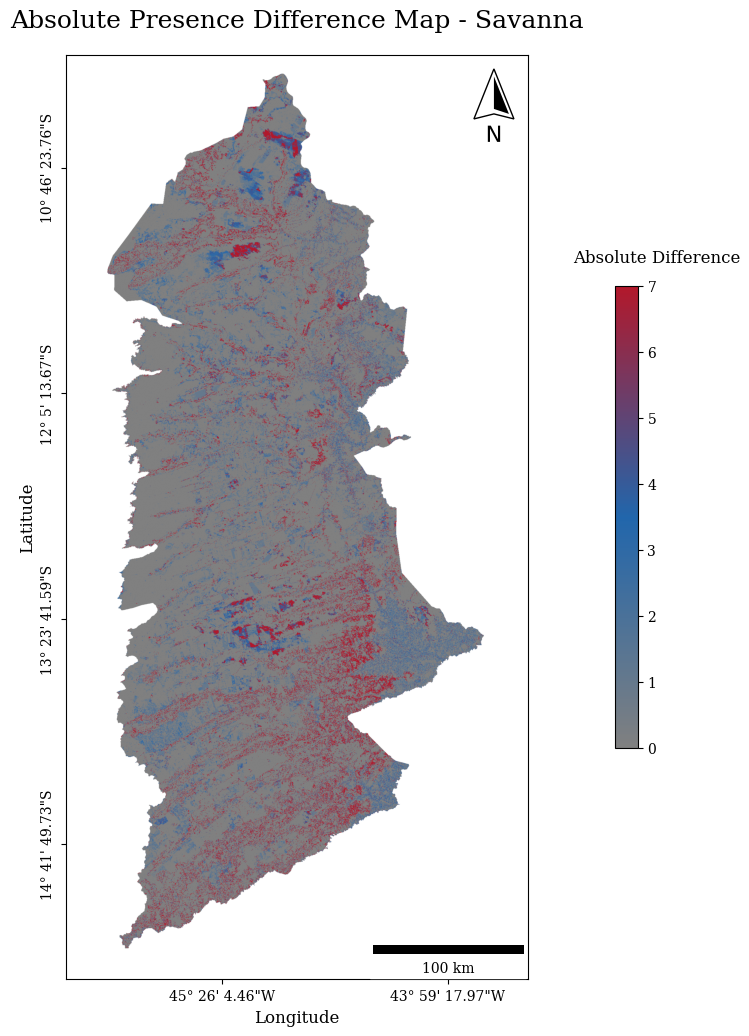


✅ Map visualization saved to: C:\Users\AntFonseca\github\compare-time-series\output4\absolute_presence_difference_savanna.png


In [9]:
# =============================================================================
# 1. Prepare data and metadata for plotting
# =============================================================================
print("Generating the Absolute Presence Difference map visualization...")

# Define the path to the raster file created in the previous cell
input_map_filename = f'presence_absolute_difference_{class_name}.tif'
input_map_path = os.path.join(
    output_path,
    input_map_filename
)

# Define a scale factor to downsample the raster for efficient plotting
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    # Get spatial metadata from the source file
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Read the data, downsampling it for visualization
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    
    # Mask the NoData values
    masked_map = np.ma.masked_equal(data, nodata_value)

# =============================================================================
# 2. Setup custom diverging colormap
# =============================================================================

# Create a custom diverging colormap
colors = [
    "gray",
    "#2166ac",
    "#b2182b"
    ]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_div_cmap", colors)

# Set the color for NoData (masked values) to white
masked_map = np.ma.masked_equal(data, float(nodata_value))
cmap.set_bad(color="white")

# Find the maximum absolute value to center the colormap on zero
max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
norm = mcolors.Normalize(vmin=0.0, vmax=max_val)

# =============================================================================
# 3. Generate the plot
# =============================================================================

# --- Tick formatting functions (Degrees, Minutes, Seconds) ---
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon))
    min_val = int((abs(lon) - deg) * 60)
    sec = ((abs(lon) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat))
    min_val = int((abs(lat) - deg) * 60)
    sec = ((abs(lat) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

# --- Create the figure ---
fig, ax = plt.subplots(
    figsize=(14, 12)
)
mpl.rcParams['font.family'] = 'serif'

# --- Plot the raster image ---
im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

# --- Format axes and ticks ---
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(
    axis='x', which='major', labelsize=10, pad=4
)
ax.tick_params(
    axis='y', which='major', labelsize=10, pad=4
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va='center'
)

# --- Add cartographic elements ---
north_arrow(
    ax,
    location="upper right",
    rotation={"degrees": 0},
    shadow=False
)

scalebar = ScaleBar(
    1/1000,
    units='km',
    length_fraction=0.4,
    location='lower right',
    scale_formatter=lambda value, _: f"{int(value)} km"
)
ax.add_artist(scalebar)

# --- Create the continuous color bar ---
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.08,
    shrink=0.5
)

cbar.set_label(
    'Absolute Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)

vmin = norm.vmin
vmax = norm.vmax
ticks = np.arange(int(np.ceil(vmin)), int(np.floor(vmax)) + 1)
cbar.set_ticks(ticks)

# --- Final styling and saving ---
ax.set_aspect('equal')
ax.set_title(
    f'Absolute Presence Difference Map - {class_name.capitalize()}',
    fontsize=18,
    pad=20
)
ax.set_xlabel(
    'Longitude',
    fontsize=12
)
ax.set_ylabel(
    'Latitude',
    fontsize=12
)

output_plot_filename = f'absolute_presence_difference_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(
    final_plot_path,
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")

## Change Agreement

In [ ]:
# =============================================================================
# 1. Initialize accumulator map
# =============================================================================
print("Starting calculation for Change Agreement raster map...")

try:
    with rasterio.open(path_to_first_file) as src:
        # Copy the profile from the source raster to use when saving the output
        profile = src.profile
        height = src.height
        width = src.width
        
        # Initialize the accumulator map with zeros
        Bn_map = np.zeros((height, width), dtype=np.float32)
        
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")

except NameError:
    print("ERROR: The first map cell must be run to define variables.")
    Bn_map = None

# =============================================================================
# 2. calculate and accumulate change agreement
# =============================================================================

if Bn_map is not None:
    print("\nStarting pixel-wise calculation for each time interval...")
    
    # This mask will track pixels that are never valid across the entire series
    final_nodata_mask = np.ones_like(Bn_map, dtype=bool)

    # Iterate over TIME INTERVALS
    for i in range(1, len(time_points)):
        year_t = time_points[i]
        year_t_minus_1 = time_points[i-1]
        
        print(f"Processing interval: {year_t_minus_1}-{year_t}...")

        # Get the four required raster arrays for the interval
        array_x_t, array_y_t = get_raster_array(year_t)
        array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)

        if array_x_t is None or array_x_t_minus_1 is None:
            print(f"Warning: Data not found for interval {year_t_minus_1}-{year_t}. Skipping.")
            continue

        # Create a mask for valid data across all four arrays
        valid_mask = (
            (array_x_t != nodata_value) &
            (array_y_t != nodata_value) &
            (array_x_t_minus_1 != nodata_value) &
            (array_y_t_minus_1 != nodata_value)
        )
        
        # --- Memory-Efficient Calculation ---
        # Calculate change directly into int16 arrays to save memory
        change_x = np.subtract(array_x_t, array_x_t_minus_1, dtype=np.int16)
        change_y = np.subtract(array_y_t, array_y_t_minus_1, dtype=np.int16)

        # Calculate gains and losses from the change arrays
        gain_x = np.maximum(0, change_x)
        gain_y = np.maximum(0, change_y)
        loss_x = np.minimum(0, change_x)
        loss_y = np.minimum(0, change_y)
        
        # Calculate gain hits (Ghtn) and loss hits (Lhtn) for the interval
        Ghtn_map = np.minimum(gain_x, gain_y)
        Lhtn_map = np.maximum(loss_x, loss_y)
        
        # Accumulate the result (Ghtn - Lhtn) in-place for memory efficiency
        np.add(Bn_map, Ghtn_map, out=Bn_map, where=valid_mask)
        np.subtract(Bn_map, Lhtn_map, out=Bn_map, where=valid_mask)
        # --- End of Memory-Efficient Calculation ---
        
        final_nodata_mask &= ~valid_mask
            
    # Apply the NoData value to pixels that were never valid
    Bn_map[final_nodata_mask] = nodata_value
    
    print("\n✅ Pixel-wise calculations complete.")

# =============================================================================
# 3. save the final raster map
# =============================================================================

if Bn_map is not None:
    # Update the profile for the output data type and add compression
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )
    
    # Define the output filename and path
    output_filename_map = f'change_agreement_{class_name}.tif'
    final_map_path = os.path.join(
        output_path,
        output_filename_map
    )

    print(f"\nSaving final map to: {final_map_path}")
    
    with rasterio.open(final_map_path, 'w', **profile) as dst:
        dst.write(Bn_map, 1)
        
    print("✅ Successfully saved the Change Agreement raster map.")

In [ ]:
# =============================================================================
# 1. Prepare data and metadata for plotting
# =============================================================================
print("Generating the Change Agreement map visualization...")

# Define the path to the raster file created in the previous cell
input_map_filename = f'change_agreement_{class_name}.tif'
input_map_path = os.path.join(
    output_path,
    input_map_filename
)

# Define a scale factor to downsample the raster for efficient plotting
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    # Get spatial metadata from the source file
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Read the data, downsampling it for visualization
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    
    # Mask the NoData values
    masked_map = np.ma.masked_equal(data, nodata_value)

# =============================================================================
# 2. Setup colormap and legend
# =============================================================================

# Classify the continuous data into discrete bins for the legend
# Find the maximum value to create the class boundaries, ignoring zeros
max_val = np.ma.max(masked_map[masked_map > 0]) if np.ma.count(masked_map[masked_map > 0]) > 0 else 1.0

# Define the boundaries for 3 levels (terciles) plus the zero class
b1, b2 = max_val / 3, 2 * max_val / 3
boundaries = [0, 1e-9, b1, b2, max_val + 1] # Add a small value to isolate 0

#
colors_categories = [
    '#F1948A',  # Low agreement
    '#F9E79F',  # Medium agreement
    '#85C1E9'   # High agreement
]
colors = ['gray'] + colors_categories

cmap = ListedColormap(colors)
cmap.set_bad(color='white')
norm = BoundaryNorm(boundaries, cmap.N)

# =============================================================================
# 4. Generate the plot
# =============================================================================

# --- Tick formatting functions (Degrees, Minutes, Seconds) ---
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon))
    min_val = int((abs(lon) - deg) * 60)
    sec = ((abs(lon) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat))
    min_val = int((abs(lat) - deg) * 60)
    sec = ((abs(lat) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

# --- Create the figure ---
fig, ax = plt.subplots(
    figsize=(14, 12)
)
mpl.rcParams['font.family'] = 'serif'

# --- Plot the raster image ---
im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

# --- Format axes and ticks ---
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(
    axis='x', which='major', labelsize=10, pad=4
)
ax.tick_params(
    axis='y', which='major', labelsize=10, pad=4
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va='center'
)

# --- Add cartographic elements ---
north_arrow(
    ax,
    location="upper right",
    rotation={"degrees": 0},
    shadow=False
)

scalebar = ScaleBar(
    1/1000,
    units='km',
    length_fraction=0.4,
    location='lower right',
    scale_formatter=lambda value, _: f"{int(value)} km"
)
ax.add_artist(scalebar)

# --- Create the discrete legend with objective value ranges ---
labels_legenda = [
    '0 (No Agreement)',
    f'> 0 - {b1:.0f} (Low Agreement)',
    f'{b1:.0f} - {b2:.0f} (Medium Agreement)',
    f'> {b2:.0f} (High Agreement)'
]
patches = [mpatches.Patch(color=colors[i], label=labels_legenda[i]) for i in range(len(labels_legenda))]

legend = ax.legend(
    handles=patches,
    title='Change Agreement Value',
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=12,
    alignment='left'
)
legend.get_title().set_ha('left')
for text in legend.get_texts():
    text.set_ha('left')

# --- Final styling and saving ---
ax.set_aspect('equal')
ax.set_title(
    f'Change Agreement Map - {class_name.capitalize()}',
    fontsize=18,
    pad=20
)
ax.set_xlabel(
    'Longitude',
    fontsize=12
)
ax.set_ylabel(
    'Latitude',
    fontsize=12
)

output_plot_filename = f'change_agreement_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(
    final_plot_path,
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")

In [17]:
# =============================================================================
# Change AGREEMENT raster
# - Binary mode (is_binary_data=True): counts ONLY same-direction changes
#   (gain/gain or loss/loss). Stable–stable and opposite-direction changes = 0.
# - Continuous mode (is_binary_data=False): Eq. 51 (agreement of change)
#   agree_interval = min(gain_x, gain_y) + max(loss_x, loss_y)
# Saves GeoTIFF with dtype=float32, nodata=nodata_value, LZW compression.
# =============================================================================
print("\nComputing CHANGE AGREEMENT raster...")

# --- 1) Initialize accumulator using the first time point's spatial profile ---
first_year = time_points[0]
first_file_name = f"{class_name}{first_year}.tif"
path_to_first_file = os.path.join(path_series_x, first_file_name)

try:
    with rasterio.open(path_to_first_file) as src_ref:
        profile = src_ref.profile
        height  = src_ref.height
        width   = src_ref.width

        change_agree_sum = np.zeros((height, width), dtype=np.float32)
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")
except FileNotFoundError:
    print(f"ERROR: Could not open '{path_to_first_file}' to initialize the map.")
    change_agree_sum = None

# --- 2) Loop over intervals and accumulate agreement ---
if change_agree_sum is not None:
    print("\nStarting interval-wise calculation...")

    # Track pixels that are NEVER valid across all intervals
    final_nodata_mask = np.ones_like(change_agree_sum, dtype=bool)

    for i in range(1, len(time_points)):
        t1 = time_points[i]
        t0 = time_points[i - 1]

        file_t1 = f"{class_name}{t1}.tif"
        file_t0 = f"{class_name}{t0}.tif"

        path_x1 = os.path.join(path_series_x, file_t1)
        path_y1 = os.path.join(path_series_y, file_t1)
        path_x0 = os.path.join(path_series_x, file_t0)
        path_y0 = os.path.join(path_series_y, file_t0)

        if (os.path.exists(path_x1) and os.path.exists(path_y1) and
            os.path.exists(path_x0) and os.path.exists(path_y0)):

            print(f"Processing interval: {t0}-{t1}...")

            with rasterio.open(path_x1) as src_x1, \
                 rasterio.open(path_y1) as src_y1, \
                 rasterio.open(path_x0) as src_x0, \
                 rasterio.open(path_y0) as src_y0:

                ax1_u8 = src_x1.read(1)
                ay1_u8 = src_y1.read(1)
                ax0_u8 = src_x0.read(1)
                ay0_u8 = src_y0.read(1)

                # valid when all four inputs at both times are not NoData
                valid = (
                    (ax1_u8 != nodata_value) &
                    (ay1_u8 != nodata_value) &
                    (ax0_u8 != nodata_value) &
                    (ay0_u8 != nodata_value)
                )

                if is_binary_data:
                    # ---------------------------------------------------------
                    # BINARY MODE: count same-direction changes only
                    # ---------------------------------------------------------
                    x0 = (ax0_u8 == 1)
                    x1 = (ax1_u8 == 1)
                    y0 = (ay0_u8 == 1)
                    y1 = (ay1_u8 == 1)

                    gain_x = (~x0) & x1          # 0 -> 1
                    loss_x = x0 & (~x1)          # 1 -> 0
                    gain_y = (~y0) & y1
                    loss_y = y0 & (~y1)

                    agree_interval = (
                        (gain_x & gain_y) | (loss_x & loss_y)
                    ).astype(np.float32)

                else:
                    # ---------------------------------------------------------
                    # CONTINUOUS MODE: Eq. 51 (agreement of change)
                    # ---------------------------------------------------------
                    ax1 = ax1_u8.astype(np.int16)
                    ay1 = ay1_u8.astype(np.int16)
                    ax0 = ax0_u8.astype(np.int16)
                    ay0 = ay0_u8.astype(np.int16)

                    dx = (ax1 - ax0).astype(np.float32)
                    dy = (ay1 - ay0).astype(np.float32)

                    gain_x = np.maximum(dx, 0.0)  # non-negative
                    gain_y = np.maximum(dy, 0.0)
                    loss_x = np.minimum(dx, 0.0)  # non-positive
                    loss_y = np.minimum(dy, 0.0)

                    agree_gain = np.minimum(gain_x, gain_y)
                    agree_loss = np.maximum(loss_x, loss_y)

                    agree_interval = (agree_gain + agree_loss).astype(np.float32)

                # accumulate only at valid pixels
                np.add(
                    change_agree_sum,
                    agree_interval,
                    out=change_agree_sum,
                    where=valid
                )

                # update final nodata mask
                final_nodata_mask &= ~valid

        else:
            print(f"Warning: Missing files for interval {t0}-{t1}. Skipping.")

    # Assign NoData where never valid in any interval
    change_agree_sum[final_nodata_mask] = nodata_value

    print("\n✅ Interval-wise accumulation complete.")

    # --- 3) Save GeoTIFF with SAME settings used elsewhere ---
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )

    output_filename = f'change_agreement_{class_name}.tif'
    final_out_path = os.path.join(output_path, output_filename)

    print(f"\nSaving final map to: {final_out_path}")
    with rasterio.open(final_out_path, 'w', **profile) as dst:
        dst.write(change_agree_sum, 1)

    print("✅ Successfully saved CHANGE AGREEMENT raster.")

else:
    print("⚠️ Skipped: could not initialize accumulator.")



Computing CHANGE AGREEMENT raster...
Accumulator map initialized with dimensions: 20480x10240.

Starting interval-wise calculation...
Processing interval: 1990-1995...
Processing interval: 1995-2000...
Processing interval: 2000-2005...
Processing interval: 2005-2010...
Processing interval: 2010-2015...
Processing interval: 2015-2020...

✅ Interval-wise accumulation complete.

Saving final map to: C:\Users\AntFonseca\github\compare-time-series\output4\change_agreement_savanna.tif
✅ Successfully saved CHANGE AGREEMENT raster.


Generating the Change Agreement map visualization...


C:\Users\AntFonseca\AppData\Local\Temp\ipykernel_9236\2753644668.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap('RdYlBu')


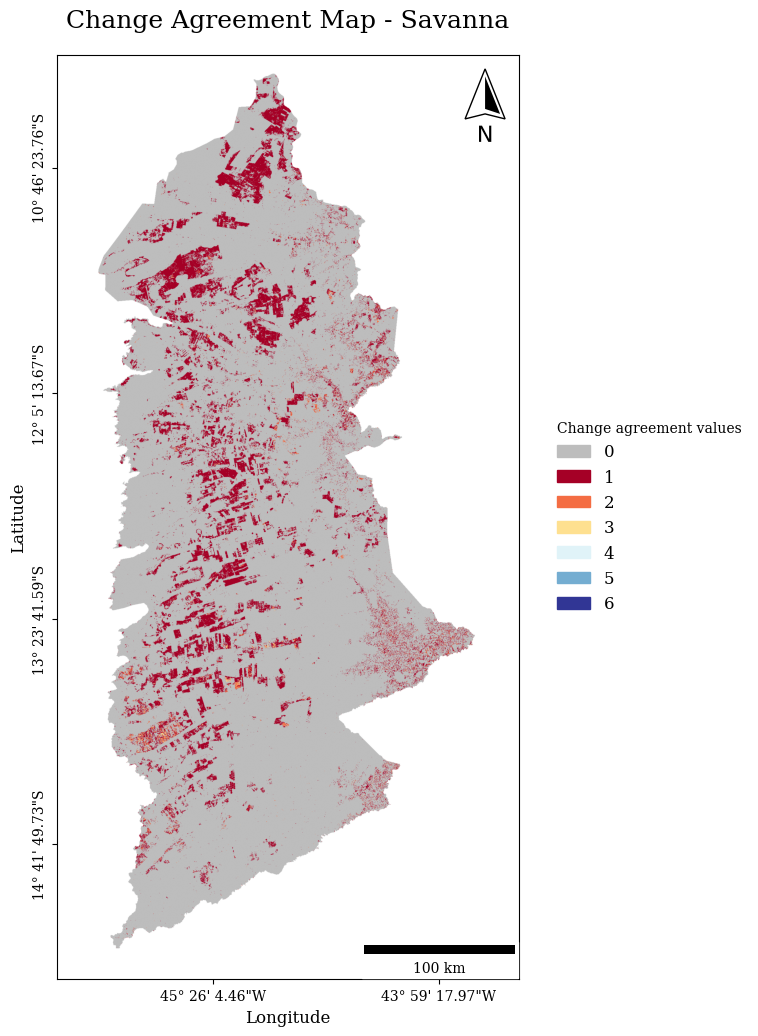


✅ Map visualization saved to: C:\Users\AntFonseca\github\compare-time-series\output4\change_agreement_savanna.png


In [19]:
# =============================================================================
# Change AGREEMENT map visualization (0=gray, 1..N red→yellow→blue, NoData=white)
# - Binary: discrete integers 0..N with legend
# - Continuous: 0=gray, positive values on RdYlBu scale, numeric colorbar
# =============================================================================
print("Generating the Change Agreement map visualization...")

# Input raster
input_map_filename = f'change_agreement_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)

# Downsample factor
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# Mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# Tick formatters
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon)); mins = int((abs(lon) - deg) * 60)
    secs = ((abs(lon) - deg) * 60 - mins) * 60
    return f"{deg}° {mins}' {secs:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat)); mins = int((abs(lat) - deg) * 60)
    secs = ((abs(lat) - deg) * 60 - mins) * 60
    return f"{deg}° {mins}' {secs:.2f}\"" + ("N" if lat >= 0 else "S")

fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

if is_binary_data:
    # Discrete integers 0..N
    n_intervals = max(0, len(time_points) - 1)
    boundaries = np.arange(-0.5, n_intervals + 1.5, 1.0)

    base = plt.cm.get_cmap('RdYlBu')
    ryb = [mcolors.to_hex(base(x)) for x in np.linspace(0.0, 1.0, max(n_intervals, 1))]
    colors = ['#bdbdbd'] + ryb[:n_intervals]

    cmap = ListedColormap(colors)
    cmap.set_bad(color='white')
    norm = BoundaryNorm(boundaries, cmap.N)

    im = ax.imshow(
        masked_map,
        cmap=cmap,
        norm=norm,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )

    patches = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(n_intervals + 1)]
    legend = ax.legend(
        handles=patches,
        title='Change agreement values',
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        alignment='left'
    )
    legend.get_title().set_ha('left')
    for text in legend.get_texts():
        text.set_ha('left')

else:
    # Continuous: 0=gray → RdYlBu
    max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
    base = plt.cm.get_cmap('RdYlBu')
    colors = ["#bdbdbd"] + [mcolors.to_hex(base(x)) for x in np.linspace(0.0, 1.0, 256)]
    cmap = ListedColormap(colors)
    cmap.set_bad(color="white")
    norm = mcolors.Normalize(vmin=0.0, vmax=max_val)

    im = ax.imshow(
        masked_map,
        cmap=cmap,
        norm=norm,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )

    cbar = fig.colorbar(
        im,
        ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.08,
        shrink=0.5
    )
    cbar.set_label(
        'Change agreement (sum over intervals)',
        fontsize=12,
        rotation=0,
        y=1.08,
        labelpad=0
    )
    ticks = np.linspace(0, max_val, num=6)
    cbar.set_ticks(ticks)

# Axes formatting
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

# Cartographic elements
north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

# Title and labels
ax.set_title(f'Change Agreement Map - {class_name.capitalize()}', fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_aspect('equal')

# Save
output_plot_filename = f'change_agreement_{class_name}.png'
final_plot_path = os.path.join(output_path, output_plot_filename)
plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")


## Change Difference

In [12]:
# =============================================================================
# 1. Initialize accumulator map
# =============================================================================
print("Starting calculation for Change Difference Map...")

try:
    with rasterio.open(path_to_first_file) as src:
        # Copy the profile from the source raster to use when saving the output
        profile = src.profile
        height = src.height
        width = src.width
        
        # Initialize the accumulator map with zeros
        En_map = np.zeros((height, width), dtype=np.float32)
        
        print(f"Accumulator map initialized with dimensions: {height}x{width}.")

except NameError:
    print("ERROR: The first map cell must be run to define variables.")
    En_map = None

# =============================================================================
# 2. Calculate and accumulate change differences
# =============================================================================

if En_map is not None:
    print("\nStarting pixel-wise calculation for each time interval...")
    
    # This mask will track pixels that are never valid across the entire series
    final_nodata_mask = np.ones_like(En_map, dtype=bool)

    # Iterate over TIME INTERVALS
    for i in range(1, len(time_points)):
        year_t = time_points[i]
        year_t_minus_1 = time_points[i-1]
        
        print(f"Processing interval: {year_t_minus_1}-{year_t}...")

        # Get the four required raster arrays for the interval
        array_x_t, array_y_t = get_raster_array(year_t)
        array_x_t_minus_1, array_y_t_minus_1 = get_raster_array(year_t_minus_1)

        if array_x_t is None or array_x_t_minus_1 is None:
            print(f"Warning: Data not found for interval {year_t_minus_1}-{year_t}. Skipping.")
            continue

        # Create a mask for valid data across all four arrays
        valid_mask = (
            (array_x_t != nodata_value) &
            (array_y_t != nodata_value) &
            (array_x_t_minus_1 != nodata_value) &
            (array_y_t_minus_1 != nodata_value)
        )
        
        # --- Memory-Efficient Calculation ---
        # Calculate change in each series directly into int16 arrays
        change_x = np.subtract(array_x_t, array_x_t_minus_1, dtype=np.int16)
        change_y = np.subtract(array_y_t, array_y_t_minus_1, dtype=np.int16)
        
        # Calculate the difference between the changes for the interval
        difference_of_changes = np.subtract(change_y, change_x, dtype=np.int16)
        
        # Accumulate the result in-place for memory efficiency
        np.add(
            En_map,
            difference_of_changes,
            out=En_map,
            where=valid_mask
        )
        # --- End of Memory-Efficient Calculation ---
        
        final_nodata_mask &= ~valid_mask
            
    # Apply the NoData value to pixels that were never valid
    En_map[final_nodata_mask] = nodata_value
    
    print("\n ✅Pixel-wise calculations complete.")

# =============================================================================
# 3. Save the final raster map
# =============================================================================

if En_map is not None:
    # Update the profile for the output data type and add compression
    profile.update(
        dtype=rasterio.float32,
        nodata=nodata_value,
        compress='lzw'
    )
    
    # Define the output filename and path
    output_filename_map = f'change_difference_{class_name}.tif'
    final_map_path = os.path.join(
        output_path,
        output_filename_map
    )

    print(f"\nSaving final map to: {final_map_path}")
    
    with rasterio.open(final_map_path, 'w', **profile) as dst:
        dst.write(En_map, 1)
        
    print("✅ Successfully saved the Change Difference map.")

Starting calculation for Change Difference Map...
Accumulator map initialized with dimensions: 20480x10240.

Starting pixel-wise calculation for each time interval...
Processing interval: 1990-1995...
Processing interval: 1995-2000...
Processing interval: 2000-2005...
Processing interval: 2005-2010...
Processing interval: 2010-2015...
Processing interval: 2015-2020...

 ✅Pixel-wise calculations complete.

Saving final map to: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_savanna.tif
✅ Successfully saved the Change Difference map.


In [ ]:
# =============================================================================
# 1. Prepare data and metadata for plotting
# =============================================================================
print("Generating the Change Difference map visualization...")

# Define the path to the raster file created in the previous cell
input_map_filename = f'change_difference_{class_name}.tif'
input_map_path = os.path.join(
    output_path,
    input_map_filename
)

# Define a scale factor to downsample the raster for efficient plotting
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    # Get spatial metadata from the source file
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Read the data, downsampling it for visualization
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    
    # Mask the NoData values
    masked_map = np.ma.masked_equal(data, nodata_value)

# =============================================================================
# 2. Setup custom diverging colormap
# =============================================================================

# Create a custom diverging colormap: Purple -> Gray -> Green
colors = [
    "#8e44ad",
    "gray", 
    "#27ae60"
    ]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_div_cmap", colors)

# Set the color for NoData (masked values) to white
cmap.set_bad(color='white')

# Find the maximum absolute value to center the colormap on zero
max_abs_val = np.ma.max(np.abs(masked_map))
norm = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)

# =============================================================================
# 3. generate the plot
# =============================================================================

# --- Tick formatting functions (Degrees, Minutes, Seconds) ---
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon))
    min_val = int((abs(lon) - deg) * 60)
    sec = ((abs(lon) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat))
    min_val = int((abs(lat) - deg) * 60)
    sec = ((abs(lat) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

# --- Create the figure ---
fig, ax = plt.subplots(
    figsize=(14, 12)
)
mpl.rcParams['font.family'] = 'serif'

# --- Plot the raster image ---
im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

# --- Format axes and ticks ---
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(
    axis='x', which='major', labelsize=10, pad=4
)
ax.tick_params(
    axis='y', which='major', labelsize=10, pad=4
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va='center'
)

# --- Add cartographic elements ---
north_arrow(
    ax,
    location="upper right",
    rotation={"degrees": 0},
    shadow=False
)

scalebar = ScaleBar(
    1/1000,
    units='km',
    length_fraction=0.4,
    location='lower right',
    scale_formatter=lambda value, _: f"{int(value)} km"
)
ax.add_artist(scalebar)

# --- Create the continuous color bar ---
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.09, # Increased padding to avoid overlap
    shrink=0.5
)
cbar.set_label(
    'Accumulated Change Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)
vmin = norm.vmin
vmax = norm.vmax
ticks = np.arange(int(np.ceil(vmin)), int(np.floor(vmax)) + 1)
cbar.set_ticks(ticks)

# --- Final styling and saving ---
ax.set_aspect('equal')
ax.set_title(
    f'Change Difference Map - {class_name.capitalize()}',
    fontsize=18,
    pad=20
)
ax.set_xlabel(
    'Longitude',
    fontsize=12
)
ax.set_ylabel(
    'Latitude',
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

output_plot_filename = f'change_difference_{class_name}_col6_10_map.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(
    final_plot_path,
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")

In [20]:
# =============================================================================
# Change DIFFERENCE rasters (signed = Eq. 53; absolute = Eq. 54)
# =============================================================================
print("\nComputing CHANGE DIFFERENCE rasters (signed & absolute)...")

first_year = time_points[0]
ref_path = os.path.join(path_series_x, f"{class_name}{first_year}.tif")

with rasterio.open(ref_path) as src_ref:
    profile = src_ref.profile
    height  = src_ref.height
    width   = src_ref.width

diff_change_signed  = np.zeros((height, width), dtype=np.float32)
diff_change_abs_sum = np.zeros((height, width), dtype=np.float32)

# pixels never valid in any interval
final_nodata_mask = np.ones((height, width), dtype=bool)

for i in range(1, len(time_points)):
    t1 = time_points[i]
    t0 = time_points[i - 1]

    px1 = os.path.join(path_series_x, f"{class_name}{t1}.tif")
    py1 = os.path.join(path_series_y, f"{class_name}{t1}.tif")
    px0 = os.path.join(path_series_x, f"{class_name}{t0}.tif")
    py0 = os.path.join(path_series_y, f"{class_name}{t0}.tif")

    if not (os.path.exists(px1) and os.path.exists(py1) and os.path.exists(px0) and os.path.exists(py0)):
        print(f"Warning: missing files for interval {t0}-{t1}; skipping.")
        continue

    with rasterio.open(px1) as sx1, rasterio.open(py1) as sy1, \
         rasterio.open(px0) as sx0, rasterio.open(py0) as sy0:

        ax1 = sx1.read(1).astype(np.int16)
        ay1 = sy1.read(1).astype(np.int16)
        ax0 = sx0.read(1).astype(np.int16)
        ay0 = sy0.read(1).astype(np.int16)

        valid = (
            (ax1 != nodata_value) & (ay1 != nodata_value) &
            (ax0 != nodata_value) & (ay0 != nodata_value)
        )

        # --- CHANGE for x and y in the interval (allow negatives) ---
        dx = (ax1 - ax0).astype(np.float32)
        dy = (ay1 - ay0).astype(np.float32)

        # --- Eq. 53: signed change difference for the interval ---
        d_signed = np.zeros_like(dx, dtype=np.float32)
        d_signed[valid] = (dy[valid] - dx[valid])

        # --- Eq. 54: absolute change difference for the interval ---
        d_abs = np.zeros_like(dx, dtype=np.float32)
        d_abs[valid] = np.abs(dy[valid] - dx[valid])

        # accumulate through intervals
        np.add(diff_change_signed,  d_signed, out=diff_change_signed,  where=valid)
        np.add(diff_change_abs_sum, d_abs,    out=diff_change_abs_sum, where=valid)

        final_nodata_mask &= ~valid

# assign NoData to pixels never valid
diff_change_signed[final_nodata_mask]  = nodata_value
diff_change_abs_sum[final_nodata_mask] = nodata_value

# save with same settings used elsewhere
profile.update(dtype=rasterio.float32, nodata=nodata_value, compress='lzw')

out_signed = os.path.join(output_path, f'change_difference_signed_{class_name}.tif')
out_abs    = os.path.join(output_path, f'change_difference_absolute_{class_name}.tif')

with rasterio.open(out_signed, 'w', **profile) as dst:
    dst.write(diff_change_signed, 1)
with rasterio.open(out_abs, 'w', **profile) as dst:
    dst.write(diff_change_abs_sum, 1)

print("✅ Saved:", out_signed)
print("✅ Saved:", out_abs)



Computing CHANGE DIFFERENCE rasters (signed & absolute)...
✅ Saved: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_signed_savanna.tif
✅ Saved: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_absolute_savanna.tif


Generating the (absolute) Change Difference map visualization...


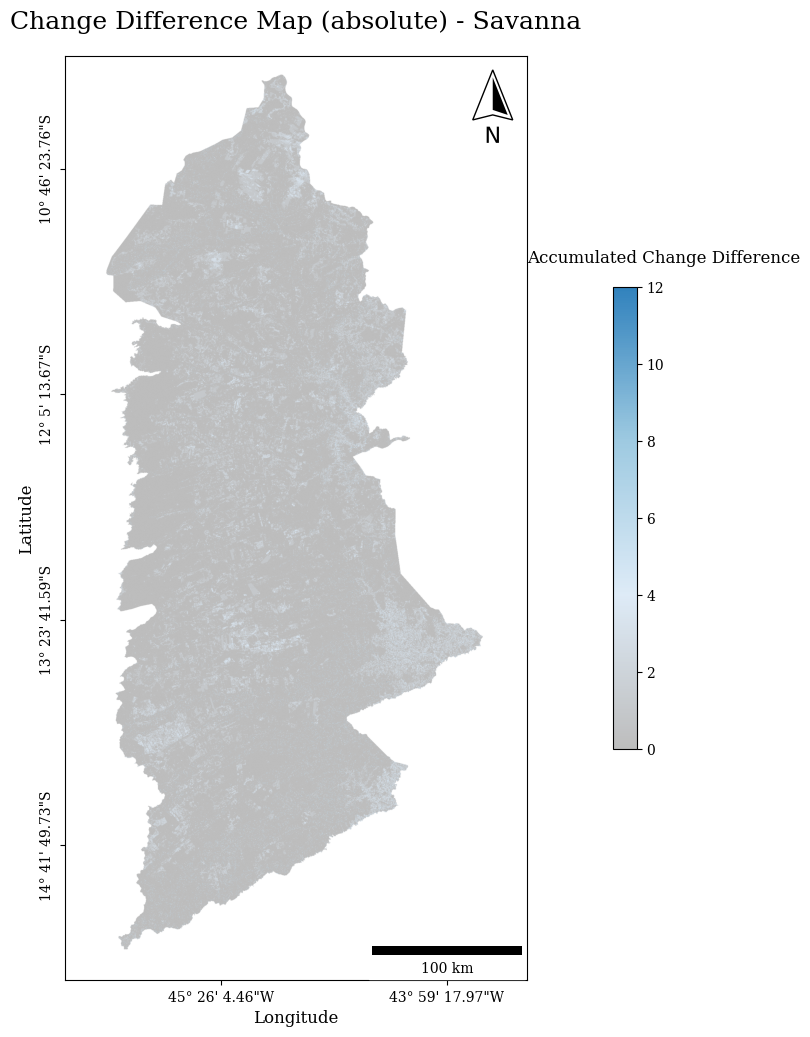


✅ Map visualization saved to: C:\Users\AntFonseca\github\compare-time-series\output4\change_difference_absolute_savanna_map.png


In [26]:
# =============================================================================
# Change DIFFERENCE (absolute, Eq. 54) — 0 = gray, NoData = white
# Colorbar outside using the same placement style as your reference cell
# =============================================================================
print("Generating the (absolute) Change Difference map visualization...")

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Input raster (absolute difference over intervals)
input_map_filename = f'change_difference_absolute_{class_name}.tif'
input_map_path = os.path.join(output_path, input_map_filename)

# Downsample factor
scale_factor = 0.15

with rasterio.open(input_map_path) as src:
    bounds = src.bounds
    src_crs = src.crs
    transform = src.transform
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor),
                   int(src.width * scale_factor)),
        resampling=Resampling.nearest
    )

# Mask NoData
masked_map = np.ma.masked_equal(data, nodata_value)

# Sequential colormap: gray -> light/dark blue; NoData = white
cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_to_blue", ["#bdbdbd", "#deebf7", "#9ecae1", "#3182bd"]
)
cmap.set_bad(color="white")

# Normalize from 0 to max
max_val = float(np.ma.max(masked_map)) if masked_map.count() > 0 else 1.0
norm = mcolors.Normalize(vmin=0.0, vmax=max_val)

# --- Tick formatters (DMS) ---
def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bounds.bottom)
    deg = int(abs(lon)); mins = int((abs(lon) - deg) * 60)
    secs = ((abs(lon) - deg) * 60 - mins) * 60
    return f"{deg}° {mins}' {secs:.2f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(bounds.left, y)
    deg = int(abs(lat)); mins = int((abs(lat) - deg) * 60)
    secs = ((abs(lat) - deg) * 60 - mins) * 60
    return f"{deg}° {mins}' {secs:.2f}\"" + ("N" if lat >= 0 else "S")

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 12))
mpl.rcParams['font.family'] = 'serif'

im = ax.imshow(
    masked_map,
    cmap=cmap,
    norm=norm,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
)

# Axes formatting
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.tick_params(axis='x', which='major', labelsize=10, pad=4)
ax.tick_params(axis='y', which='major', labelsize=10, pad=4)
plt.setp(ax.get_yticklabels(), rotation=90, va='center')

# Cartographic elements
north_arrow(ax, location="upper right", rotation={"degrees": 0}, shadow=False)
scalebar = ScaleBar(1/1000, units='km', length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)

# # Colorbar OUTSIDE (same placement style as your reference)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="3.5%", pad=0.12)

# --- Create the continuous color bar ---
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.08,
    shrink=0.5
)

cbar.set_label(
    'Accumulated Change Difference',
    fontsize=12,
    rotation=0,
    y=1.08,
    labelpad=0
)

# Ticks: integers if binary, linear otherwise
if is_binary_data:
    n_int = max(0, len(time_points) - 1)          # number of intervals
    # Per-interval |Δy-Δx| ∈ {0,1,2} → total range 0..2*n_int
    tick_max = int(min(2*n_int, np.floor(max_val)))
    cbar.set_ticks(np.arange(0, tick_max + 1, max(1, tick_max // 5 or 1)))
else:
    cbar.set_ticks(np.linspace(0, max_val, num=6))

# Final styling and save
ax.set_aspect('equal')
ax.set_title(f'Change Difference Map (absolute) - {class_name.capitalize()}',
             fontsize=18, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

output_plot_filename = f'change_difference_absolute_{class_name}_map.png'
final_plot_path = os.path.join(output_path, output_plot_filename)

plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Map visualization saved to: {final_plot_path}")
